In [128]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns
import pandas as pd
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK, Trials, pyll, rand
import time
from numpy import random
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Input, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras import datasets, layers, models

from keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop
from keras.datasets import mnist

sns.set_theme(font_scale=1.7, style='whitegrid')

# Esercitazione 5

### Hyperopt 

Esistono vari algoritmi per fare iper-ottimizzazione. 

Quando voglio scansionare uno spazio utile cercare in modo intelligente.
`Objective` qualche cella sotto crea un *json che cresce al crescere del dizionario.

In [2]:
a = hp.loguniform('c', -5, 0)       # limiti

In [9]:
sample = []
for i in range(1000):
    sample.append(pyll.stochastic.sample(a))

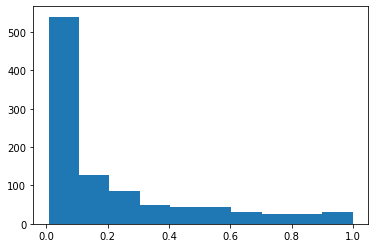

In [11]:
plt.hist(sample)
plt.show()

In [12]:
def objective(x):
    return {'loss': x**2, 'status': STATUS_OK, 'eval_time': time.time()}        #

algorithm = tpe.suggest
trials = Trials()

best = fmin(objective, space=hp.uniform('x', -10,10), algo=algorithm, max_evals=100, trials=trials)

100%|█████| 100/100 [00:00<00:00, 550.49trial/s, best loss: 0.00782706336126075]


In [19]:
print(best)
#trials.trials['tid']

{'x': 0.08847069210343474}


Costruire un dizionario come search space (griglia + lr) --> spazio + robusto su cui eseguire lo stesso procedimento.

---

__NB__ hp non salva l'elemento migliore! salva l'indice. Si usa `space_eval` per tradurre dal dizionario alla soluzione in base reale.

---

L'oggetto trials contiene delle liste. Posso estrarre `iterations = [t['tid'] for t in trials.trials]`. Altre librerie sono piu semplici come impatto, vedi documentazioni.

### RNNs

Esistono implementazioni pronte per il layer e per le celle di: `SimpleRNN, LSTM, GRU` 

In [23]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(32,1)))
#model.add(keras.layers.LSTM(10))
model.add(keras.layers.GRU(10,return_sequences=True)) # fornisce in out la sequenza --> time steps, elementi, dimensioni
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32, 10)            390       
_________________________________________________________________
dense_2 (Dense)              (None, 32, 1)             11        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [25]:
encoder_input = keras.layers.Input(shape=(None,1))
output, state_h, state_c = keras.layers.LSTM(64, return_state=True)(encoder_input)


# decoder che si mangia l'encoder
# esistono anche modelli bidirezionali

## 5.1 Hyperoptimization

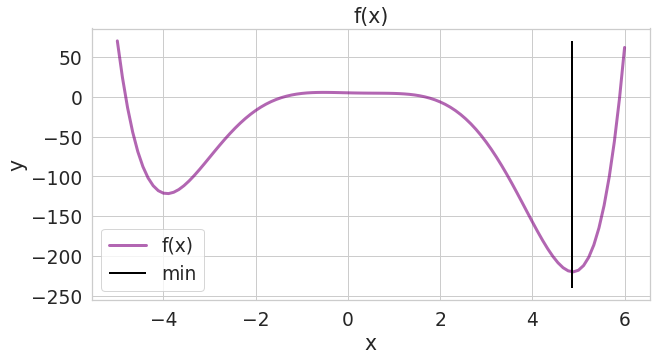

In [121]:
def f(x):
    return 0.05*(x**6 - 2*x**5 - 28*x**4 + 28*x**3 + 12*x**2 - 26*x + 100)

def obj(x):
    return f(x)

def plot_scatter(x, y):
    plt.figure(figsize=(15,6))
    
    plt.subplot(1,2,1)
    plt.title('iterations vs values')
    plt.scatter(x, y, color='purple', alpha=0.5, s=20)
    plt.xlabel('iteration')
    plt.ylabel('value')
    
    plt.subplot(1,2,2)
    plt.title('Tried values')
    plt.hist(y, bins=50, color='purple', alpha=0.4)
    plt.xlabel('x')
    plt.ylabel('#')

x = np.linspace(-5,6,100)

plt.figure(figsize=(10,5))
plt.title('f(x)')
plt.plot(x, f(x), color='purple', lw=3, alpha=0.6, label='f(x)')
plt.vlines(4.87, -240, 70, color='black', lw=2, label='min')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [108]:
domain = hp.uniform('x', -5, 6)
sample = []

for i in range(100):
    sample.append(pyll.stochastic.sample(domain))

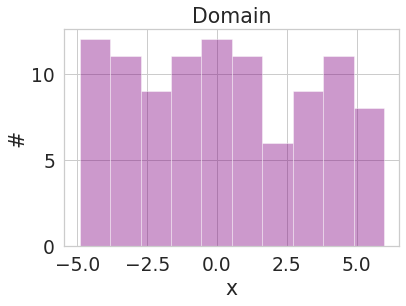

In [109]:
plt.hist(sample, alpha=0.4, color='purple')
plt.title('Domain')
plt.xlabel('x')
plt.ylabel('#')
plt.show()

In [110]:
trials = Trials()
tpe_algorithm = tpe.suggest

tpe_best = fmin(obj, space=domain, algo=tpe_algorithm, max_evals=2000, trials=trials)

100%|███| 2000/2000 [00:11<00:00, 177.29trial/s, best loss: -219.80118397125898]


In [111]:
print(tpe_best)

tpe_values = trials.vals['x']
tpe_iterations = [ t['tid'] for t in trials.trials]

{'x': 4.878524791064197}


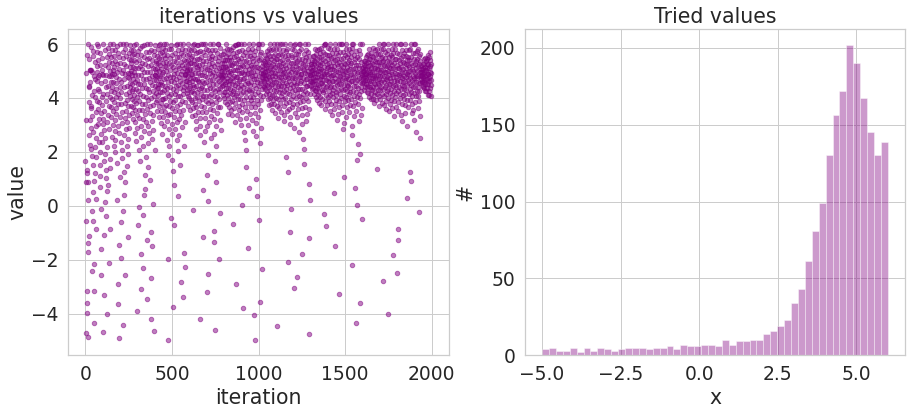

In [112]:
plot_scatter(tpe_iterations, tpe_values)

In [113]:
trials = Trials()
algorithm = rand.suggest

rnd_best = fmin(obj, space=domain, algo=algorithm, max_evals=2000, trials=trials)

100%|███| 2000/2000 [00:03<00:00, 535.26trial/s, best loss: -219.79565061495023]


In [114]:
print(best)

rnd_values = trials.vals['x']

{'x': 4.8794915056322825}


In [115]:
rnd_iterations = [ t['tid'] for t in trials.trials]

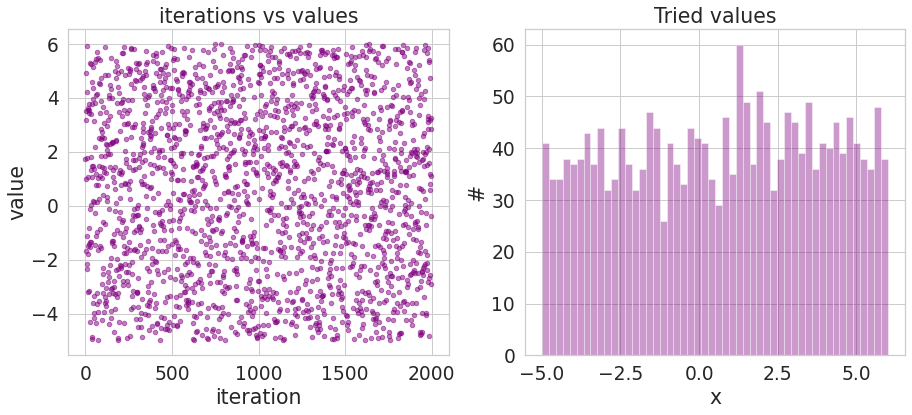

In [116]:
plot_scatter(rnd_iterations, rnd_values)

`mongodb` per costruire database in stile python (diventano dei `*.json`). Con la versione `MongoTrials` posso collegare hyperopt e le trials con la struttura di `mongodb`. 

## 5.1 - Hyperparameter scan for classifier

In [181]:
def data():
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    return x_train, y_train, x_test, y_test

In [185]:
space = { 'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
          'n_layers': hp.uniformint('n_layers',0, 3), 
          'n_nodes' : hp.uniformint('n_nodes',1, 100) }

x_train, y_train, x_test, y_test = data()

In [186]:
#--------------------------------------------------------------------
# test function
def test(model, features, labels):
    res = model.evaluate(features, labels)
    return res


#--------------------------------------------------------------------
# generate a neural network
def spawn_NN(space):
    
    #selection of the hyperpars
    learning_rate = space['learning_rate']
    n_layers = space['n_layers']
    n_nodes = space['n_nodes']

    #building up my model
    NN = Sequential()
    NN.add(Flatten(input_shape=(28,28)))
    for i in range(n_layers): 
        NN.add(Dense(n_nodes, activation='relu'))

    #compile the model
    NN.compile(loss=keras.losses.sparse_categorical_crossentropy,
               optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    #train the model
    NN.fit(x_train, y_train, epochs=5)

    #evaluate test performance
    test_acc = test(NN, x_test, y_test)
    
    return NN

In [187]:
best_classifier = fmin(spawn_NN, space, algo=tpe.suggest, max_evals=10)
print(best_classifier)

Epoch 1/5                                                                       
   1/1875 [..............................]                                      
 - ETA: 2:58 - loss: 20.6512 - accuracy: 0.0000e+00                             
                                                                                
  87/1875 [>.............................]                                      
 - ETA: 1s - loss: 20.6949 - accuracy: 0.0000e+00                               
                                                                                
 173/1875 [=>............................]                                      
 - ETA: 0s - loss: 20.6945 - accuracy: 0.0000e+00                               
                                                                                
 255/1875 [===>..........................]                                      
 - ETA: 0s - loss: 20.6962 - accuracy: 0.0000e+00                               
                            

 - ETA: 0s - loss: 20.6896 - accuracy: 0.0000e+00                               
                                                                                
 831/1875 [============>.................]                                      
 - ETA: 0s - loss: 20.6897 - accuracy: 0.0000e+00                               
                                                                                
 914/1875 [=============>................]                                      
 - ETA: 0s - loss: 20.6901 - accuracy: 0.0000e+00                               
                                                                                
 999/1875 [==============>...............]                                      
 - ETA: 0s - loss: 20.6902 - accuracy: 0.0000e+00                               
                                                                                
1085/1875 [================>.............]                                      
 - ETA: 0s - loss: 20.6909 -

1598/1875 [========================>.....]                                      
 - ETA: 0s - loss: 20.6896 - accuracy: 0.0000e+00                               
                                                                                
1678/1875 [=========================>....]                                      
 - ETA: 0s - loss: 20.6894 - accuracy: 0.0000e+00                               
                                                                                
1763/1875 [===========================>..]                                      
 - ETA: 0s - loss: 20.6890 - accuracy: 0.0000e+00                               
                                                                                
1849/1875 [============================>.]                                      
 - ETA: 0s - loss: 20.6896 - accuracy: 0.0000e+00                               
                                                                                
1875/1875 [=================

                                                                                
 431/1875 [=====>........................]                                      
 - ETA: 0s - loss: 20.6909 - accuracy: 0.0000e+00                               
                                                                                
 518/1875 [=======>......................]                                      
 - ETA: 0s - loss: 20.6894 - accuracy: 0.0000e+00                               
                                                                                
 604/1875 [========>.....................]                                      
 - ETA: 0s - loss: 20.6887 - accuracy: 0.0000e+00                               
                                                                                
 691/1875 [==========>...................]                                      
 - ETA: 0s - loss: 20.6900 - accuracy: 0.0000e+00                               
                            

job exception: 'Sequential' object is not iterable



  0%|                                    | 0/10 [00:06<?, ?trial/s, best loss=?]


TypeError: 'Sequential' object is not iterable

In [172]:
best_classifier

NameError: name 'best_classifier' is not defined